Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, accuracy_score,
                             precision_score, recall_score, f1_score)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

Load the Cleaned Dataset

In [3]:
from google.colab import files
uploaded = files.upload()

Saving CreditCardData_Cleaned.csv to CreditCardData_Cleaned.csv


In [4]:
df = pd.read_csv('CreditCardData_Cleaned.csv')

In [5]:
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset info:")
print(df.info())

Dataset shape: (14997, 39)

First few rows:
   Day of Week  Time  Type of Card  Amount  Gender   Age  Fraud  \
0            2    19             1    21.0       1  46.1      0   
1            1     0             1     6.0       1  52.0      1   
2            1     9             0     7.0       1  43.9      0   
3            2    20             1    17.0       0  31.5      1   
4            2    11             1    27.0       0  33.8      1   

   Entry Mode_PIN  Entry Mode_Tap  Type of Transaction_Online  ...  \
0           False           False                        True  ...   
1           False           False                        True  ...   
2            True           False                       False  ...   
3           False           False                        True  ...   
4           False           False                        True  ...   

   Country of Residence_Russia  Country of Residence_USA  \
0                        False                     False   
1           

Prepare Data for Training

In [6]:
# Separate features and target
X = df.drop('Fraud', axis=1)
y = df['Fraud']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFraud distribution:\n{y.value_counts()}")
print(f"Fraud percentage: {(y.sum() / len(y)) * 100:.2f}%")

Features shape: (14997, 38)
Target shape: (14997,)

Fraud distribution:
Fraud
0    7805
1    7192
Name: count, dtype: int64
Fraud percentage: 47.96%


In [7]:
# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training fraud: {(y_train.sum() / len(y_train)) * 100:.2f}%")
print(f"Test fraud: {(y_test.sum() / len(y_test)) * 100:.2f}%")


Training set: (11997, 38)
Test set: (3000, 38)
Training fraud: 47.95%
Test fraud: 47.97%


Feature Scaling

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Feature mean after scaling: {X_train_scaled.mean():.4f}")
print(f"Feature std after scaling: {X_train_scaled.std():.4f}")

Feature mean after scaling: 0.0000
Feature std after scaling: 1.0000


Deep Neural Network Model

In [9]:
# Build the DNN architecture
model = Sequential([
    # Input layer + First hidden layer
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu',
          name='hidden_layer_1'),
    Dropout(0.3, name='dropout_1'),  # Prevent overfitting

    # Second hidden layer
    Dense(64, activation='relu', name='hidden_layer_2'),
    Dropout(0.3, name='dropout_2'),

    # Third hidden layer
    Dense(32, activation='relu', name='hidden_layer_3'),
    Dropout(0.2, name='dropout_3'),

    # Fourth hidden layer
    Dense(16, activation='relu', name='hidden_layer_4'),
    Dropout(0.2, name='dropout_4'),

    # Output layer for binary classification
    Dense(1, activation='sigmoid', name='output_layer')
])

# Display model architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 128)            │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_3 (Dense)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_4 (Dense)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,873 (62.00 KB)

 Trainable params: 15,873 (62.00 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

print("Model compiled successfully!")

Model compiled successfully!


Set Up Callbacks

In [11]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

Train the Model

In [12]:
print("Starting training...")
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Starting training...
Epoch 1/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7212 - auc: 0.8055 - loss: 0.4997 - precision: 0.7561 - recall: 0.5676 - val_accuracy: 0.9425 - val_auc: 0.9829 - val_loss: 0.1663 - val_precision: 0.9191 - val_recall: 0.9665 - learning_rate: 0.0010
Epoch 2/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9345 - auc: 0.9758 - loss: 0.1937 - precision: 0.9238 - recall: 0.9430 - val_accuracy: 0.9454 - val_auc: 0.9861 - val_loss: 0.1443 - val_precision: 0.9279 - val_recall: 0.9622 - learning_rate: 0.0010
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9316 - auc: 0.9782 - loss: 0.1832 - precision: 0.9182 - recall: 0.9412 - val_accuracy: 0.9504 - val_auc: 0.9887 - val_loss: 0.1292 - val_precision: 0.9343 - val_recall: 0.9656 - learning_rate: 0.0010
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9392 - auc: 0.9822 - loss: 0.1612 - precision: 0.9230 - recall: 0.9532 - val_accuracy: 0.9508 - val_auc: 0.9889

Evaluate the Model

In [13]:
# Evaluate on test set
print("="*80)
print("MODEL EVALUATION ON TEST SET")
print("="*80)

test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(
    X_test_scaled, y_test, verbose=0
)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Make predictions
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate additional metrics
f1 = f1_score(y_test, y_pred)
print(f"Test F1-Score: {f1:.4f}")

MODEL EVALUATION ON TEST SET

Test Loss: 0.1116
Test Accuracy: 0.9540 (95.40%)
Test Precision: 0.9260
Test Recall: 0.9826
Test AUC: 0.9912
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test F1-Score: 0.9535


Classification Report

In [14]:
print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraud']))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Normal       0.98      0.93      0.95      1561
       Fraud       0.93      0.98      0.95      1439

    accuracy                           0.95      3000
   macro avg       0.95      0.96      0.95      3000
weighted avg       0.96      0.95      0.95      3000



Confusion Matrix Visualization

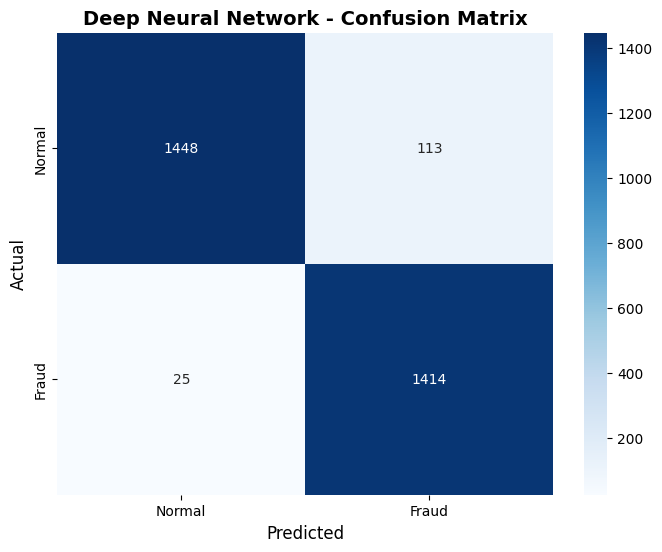


Confusion Matrix Breakdown:
True Negatives (TN): 1448
False Positives (FP): 113
False Negatives (FN): 25
True Positives (TP): 1414


In [15]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Fraud'],
            yticklabels=['Normal', 'Fraud'])
plt.title('Deep Neural Network - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.show()

# Print confusion matrix breakdown
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

ROC Curve

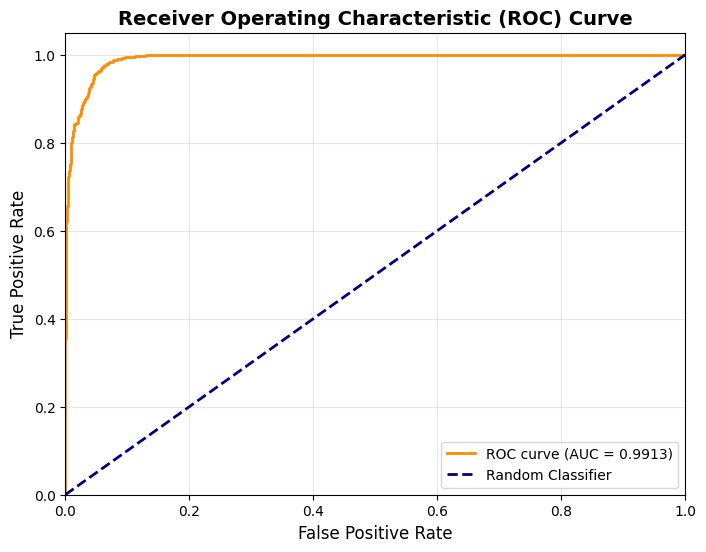

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Training History Visualization

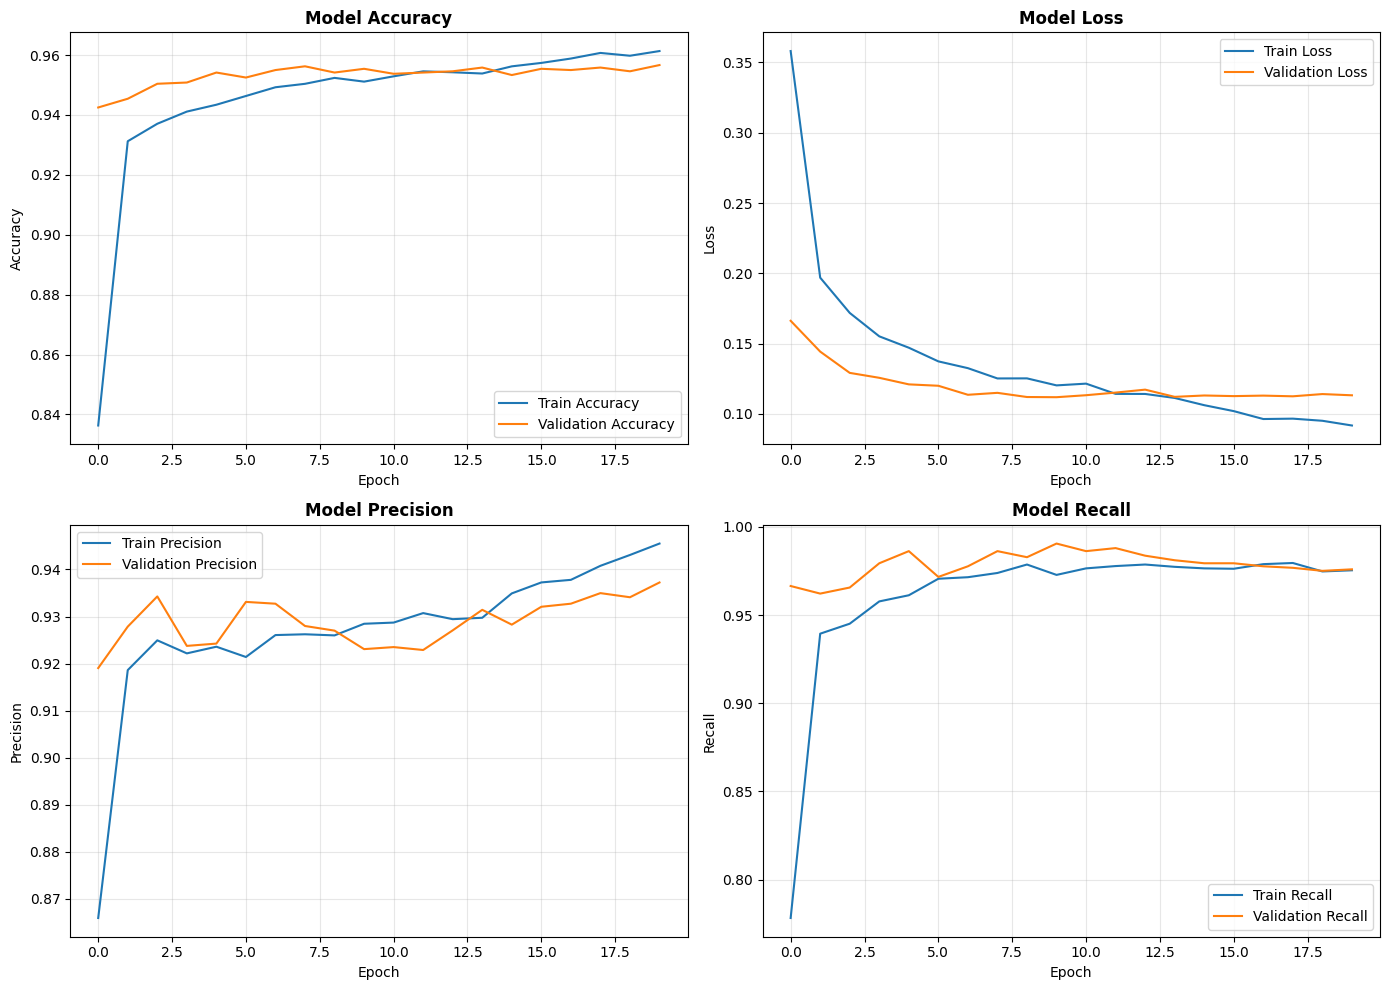

In [17]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 0].set_title('Model Accuracy', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train Loss')
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 1].set_title('Model Loss', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision')
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
axes[1, 0].set_title('Model Precision', fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall')
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
axes[1, 1].set_title('Model Recall', fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# Save the trained model
model.save('dnn_fraud_detection_model.h5')
print("Model saved as 'dnn_fraud_detection_model.h5'")

# Save the scaler
import pickle
with open('scaler_dnn.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Scaler saved as 'scaler_dnn.pkl'")

# Download files
from google.colab import files
files.download('dnn_fraud_detection_model.h5')
files.download('scaler_dnn.pkl')

Model saved as 'dnn_fraud_detection_model.h5'
Scaler saved as 'scaler_dnn.pkl'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Summary Report

In [19]:
# Final summary
print("\n" + "="*80)
print("DEEP NEURAL NETWORK - FINAL SUMMARY")
print("="*80)
print(f"\nModel Architecture:")
print(f"  - Input features: {X_train_scaled.shape[1]}")
print(f"  - Hidden layers: 4 (128, 64, 32, 16 neurons)")
print(f"  - Dropout rates: 0.3, 0.3, 0.2, 0.2")
print(f"  - Output: 1 neuron (sigmoid activation)")
print(f"  - Total parameters: {model.count_params():,}")

print(f"\nTraining Configuration:")
print(f"  - Optimizer: Adam (lr=0.001)")
print(f"  - Loss function: Binary Crossentropy")
print(f"  - Batch size: 32")
print(f"  - Epochs trained: {len(history.history['loss'])}")

print(f"\nPerformance Metrics:")
print(f"  - Accuracy: {test_accuracy*100:.2f}%")
print(f"  - Precision: {test_precision:.4f}")
print(f"  - Recall: {test_recall:.4f}")
print(f"  - F1-Score: {f1:.4f}")
print(f"  - ROC-AUC: {roc_auc:.4f}")

print(f"\nConfusion Matrix:")
print(f"  - True Positives (Fraud detected): {tp}")
print(f"  - True Negatives (Normal detected): {tn}")
print(f"  - False Positives (False alarms): {fp}")
print(f"  - False Negatives (Missed fraud): {fn}")

print(f"\nBusiness Impact:")
fraud_caught_rate = (tp / (tp + fn)) * 100
print(f"  - Fraud detection rate: {fraud_caught_rate:.2f}%")
print(f"  - Missed frauds: {fn}")
print(f"  - False alarms: {fp}")
print("="*80)


DEEP NEURAL NETWORK - FINAL SUMMARY

Model Architecture:
  - Input features: 38
  - Hidden layers: 4 (128, 64, 32, 16 neurons)
  - Dropout rates: 0.3, 0.3, 0.2, 0.2
  - Output: 1 neuron (sigmoid activation)
  - Total parameters: 15,873

Training Configuration:
  - Optimizer: Adam (lr=0.001)
  - Loss function: Binary Crossentropy
  - Batch size: 32
  - Epochs trained: 20

Performance Metrics:
  - Accuracy: 95.40%
  - Precision: 0.9260
  - Recall: 0.9826
  - F1-Score: 0.9535
  - ROC-AUC: 0.9913

Confusion Matrix:
  - True Positives (Fraud detected): 1414
  - True Negatives (Normal detected): 1448
  - False Positives (False alarms): 113
  - False Negatives (Missed fraud): 25

Business Impact:
  - Fraud detection rate: 98.26%
  - Missed frauds: 25
  - False alarms: 113
